# Step 0: Setting the environment and importing libraries

In [ ]:
# To download dataset from Kaggle
import os

os.environ['KAGGLE_USERNAME'] = " "
os.environ['KAGGLE_KEY'] = " "

import kagglehub
path = kagglehub.dataset_download("CooperUnion/anime-recommendations-database")

/Users/margo/Documents/ucu/3 year/1 semester/AI/project/project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# For working with data
import pandas as pd
import numpy as np
import math
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# For the Content-Based model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import normalize
from numpy.random import default_rng
from tqdm.notebook import tqdm

# For the Collaborative Filtering model
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from collections import defaultdict
from surprise import accuracy

# For the Hybrid model
from lightfm import LightFM
from lightfm.data import Dataset as LightFMDataset

# For saving models
import joblib
from surprise.dump import dump

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

/Users/margo/Documents/ucu/3 year/1 semester/AI/project/project/.venv/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Step 1: Loading and preparing data

## Step 1.1: Files loading

In [3]:
anime_file = f"{path}/anime.csv"
rating_file = f"{path}/rating.csv"

anime_df = pd.read_csv(anime_file)
ratings_df = pd.read_csv(rating_file)

print("Anime info:")
anime_df.info()
print("\nRatings info:")
ratings_df.info()

print("\nFirst 5 anime rows:")
display(anime_df.head())
print("\nFirst 5 ratings rows:")
display(ratings_df.head())

Anime info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB

Ratings info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB

First 5 anime rows:


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266



First 5 ratings rows:


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
print(sorted(anime_df.name.unique()))

['&quot;0&quot;', '&quot;Aesop&quot; no Ohanashi yori: Ushi to Kaeru, Yokubatta Inu', '&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi', '&quot;Bungaku Shoujo&quot; Memoire', '&quot;Bungaku Shoujo&quot; Movie', '&quot;Eiji&quot;', '&quot;Eiyuu&quot; Kaitai', '.hack//G.U. Returner', '.hack//G.U. Trilogy', '.hack//G.U. Trilogy: Parody Mode', '.hack//Gift', '.hack//Intermezzo', '.hack//Liminality', '.hack//Quantum', '.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!', '.hack//Roots', '.hack//Sign', '.hack//Tasogare no Udewa Densetsu', '.hack//Tasogare no Udewa Densetsu: Offline de Aimashou', '.hack//The Movie: Sekai no Mukou ni', '.hack//Unison', '.hack//Versus: The Thanatos Report', '0-sen Hayato', '0-sen Hayato Pilot', '001', '009 Re:Cyborg', '009 Re:Cyborg x Zip', '009-1', '009-1: R&amp;B', '00:08', '07-Ghost', '1+2=Paradise', '100%', '100-man-nen Chikyuu no Tabi: Bander Book', '1000-nen Joou: Queen Millennia', '1001 Nights', '11-nin Iru!', '11eyes', '11eyes Picture Drama', '11

*This means some names will require markdown rendering for correct visualization

## Step 1.2: Data Cleaning

As we saw, `ratings_df` contains ratings of $-1$, meaning *"the user watched but did not rate."* For rating-prediction models (like `SVD`), these records are unnecessary. Also, `anime_df` can have missing genres, which are critical for the `Content-Based` model.

In [5]:
anime_df.dropna(subset=['genre'], inplace=True)
anime_df.dropna(subset=['type'], inplace=True)
ratings_df_cleaned = ratings_df[ratings_df['rating'] != -1]

print(f"Initial number of ratings: {len(ratings_df)}")
print(f"Number of ratings after cleaning: {len(ratings_df_cleaned)}")

Initial number of ratings: 7813737
Number of ratings after cleaning: 6337241


# Step 2: Content-Based model construction

## Preparing data for vectorization

In [6]:
cb_df = anime_df.copy()

cb_df['genre'] = cb_df.get('genre', '').fillna('')
cb_df['type'] = cb_df.get('type', 'Unknown').fillna('Unknown').astype(str)

num_cols = ['members', 'episodes', 'rating']
for c in num_cols:
    if c not in cb_df.columns:
        cb_df[c] = 0
cb_df[num_cols] = cb_df[num_cols].apply(pd.to_numeric, errors='coerce').fillna(0)


We add three simple but effective upgrades:
1) **Log-scaling** heavy-tail numerics (`members`, `episodes`) → stabilizes distances.  
2) **Centering** `rating` around the global mean → removes absolute-scale bias.  
3) **Block weights** to balance text vs meta signals (grid a few options).

We'll rebuild the combined sparse matrix with these changes.

In [7]:
cb_df['members_log'] = np.log1p(cb_df['members'])
cb_df['episodes_log'] = np.log1p(cb_df['episodes'])
cb_df['rating_ctr'] = cb_df['rating'] - cb_df['rating'].replace(0, np.nan).mean()

## Step 2.1: Features vectorization

We will convert text-based names into numerical vectors so the computer can compute their similarity. The `TfidfVectorizer` is ideal for this.

In [8]:
tfidf_name = TfidfVectorizer(stop_words='english', token_pattern=r"(?u)\b\w+\b")
X_name = tfidf_name.fit_transform(cb_df['name'].fillna(''))

tfidf_genre = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
X_genre = tfidf_genre.fit_transform(cb_df['genre'])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
X_type = ohe.fit_transform(cb_df[['type']])

num_features = cb_df[['members_log', 'episodes_log', 'rating_ctr']]
scaler = StandardScaler(with_mean=False)
X_num = scaler.fit_transform(num_features)

w_name, w_genre, w_type, w_num = 1.0, 1.0, 1.0, 1.0
cb_matrix = hstack([
    w_name * X_name,
    w_genre * X_genre,
    w_type * X_type,
    w_num * csr_matrix(X_num),
], format='csr')

## Step 2.2: Computing the similarity matrix

Now we will compute the cosine similarity between all anime vectors. The result will be a matrix where each pair of anime has a value from 0 to 1 indicating how similar they are.

In [9]:
avg_ratings = (ratings_df_cleaned
               .groupby('anime_id')['rating']
               .mean()
               .reset_index())

anime_avg = anime_df.merge(avg_ratings, on='anime_id', how='left')
anime_avg['rating_y'] = anime_avg['rating_y'].fillna(0)

top20 = anime_avg.sort_values('rating_y', ascending=False).head(20)

top20_ids = top20['anime_id'].tolist()

In [10]:
ITEM_IDS = anime_df["anime_id"].astype(int).to_numpy()
ID2ROW   = {int(i): r for r, i in enumerate(ITEM_IDS)}

top20_rows = [ID2ROW[i] for i in top20_ids if i in ID2ROW]
cb_top20 = cb_matrix[top20_rows]

cosine_top20 = cosine_similarity(cb_top20)

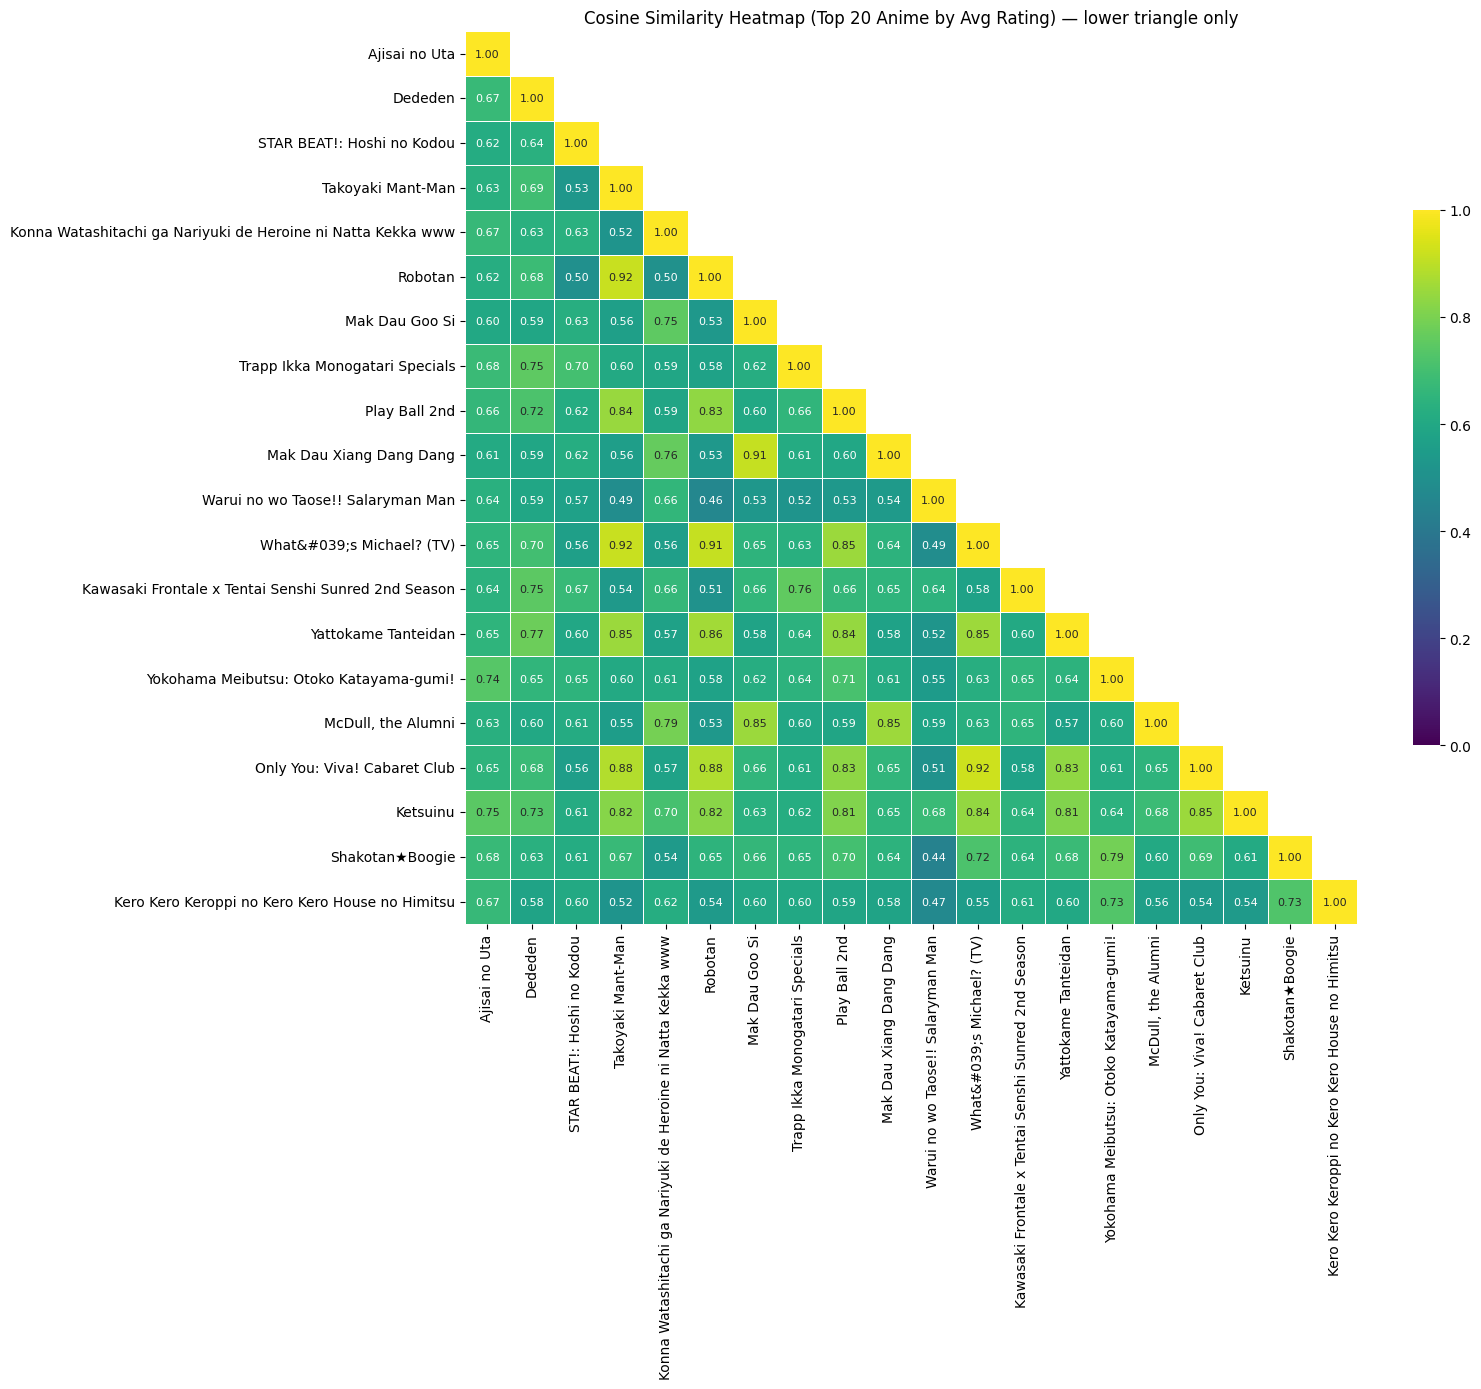

In [11]:
labels_top20 = anime_df.set_index('anime_id').loc[top20_ids]['name'].tolist()
plt.figure(figsize=(16, 14))

mask = np.triu(np.ones_like(cosine_top20, dtype=bool), k=1)

sns.heatmap(
    cosine_top20,
    mask=mask,
    xticklabels=labels_top20,
    yticklabels=labels_top20,
    cmap='viridis',
    annot=True,
    fmt=".2f",
    annot_kws={'size': 8},
    cbar_kws={'shrink': 0.6},
    vmin=0.0,
    vmax=1.0,
    linewidths=0.5
)
plt.title("Cosine Similarity Heatmap (Top 20 Anime by Avg Rating) — lower triangle only")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Step 2.3: User-level Content-Based model (weighted features)

We build a **personalized content-based recommender** that combines several feature spaces:

- **Genres** → TF-IDF representation  
- **Type** → one-hot encoded  
- **Numeric block** → `members_log`, `episodes_log`, and centered `rating`

For each user:
1. Collect watched anime from the `ratings` table  
2. Build a **user profile** by averaging the feature vectors of these items, weighted by their ratings  
3. Learn **feature importance weights** (`genres`, `type`, `num`) that maximize NDCG@K  
4. Recommend new anime based on similarity to this weighted profile  
5. Exclude anime the user has already seen (no re-recommendations)  
6. Provide a simple cold-start fallback using popularity and rating

In [12]:
INTER      = ratings_df_cleaned
USER_COL   = "user_id"
ITEM_COL   = "anime_id"
WEIGHT_COL = "rating"
USER_WEIGHTS_CACHE = {}

_item_pop = INTER.groupby(ITEM_COL).size().reindex(ITEM_IDS, fill_value=0).to_numpy().astype(float)

if not hasattr(X_num, "tocsr"):
    X_num = csr_matrix(X_num)

ITEM_VECS = {
    "name": X_name,
    "genres": X_genre,
    "type": X_type,
    "num": X_num,
}
FEATURE_ORDER = ["name", "genres", "type", "num"]

def _map_weight(x):
    try: x = float(x)
    except: return 1.0
    if x < 0: return 0.0
    return max(0.1, min(1.0, x/10.0))

USER_PROFILE = {}
for u, g in INTER[[USER_COL, ITEM_COL, WEIGHT_COL]].groupby(USER_COL):
    ids = g[ITEM_COL].astype(int).tolist()
    ws  = g[WEIGHT_COL].map(_map_weight).astype(float).tolist()
    rows = [ID2ROW[i] for i in ids if i in ID2ROW]
    ws   = [w for (i, w) in zip(ids, ws) if i in ID2ROW]
    USER_PROFILE[u] = {"seen": set(ids), "rows": np.array(rows, int), "w": np.array(ws, float)}

def _user_feature_profile(X, rows, item_w):
    if len(rows) == 0:
        return np.zeros(X.shape[1], float)
    w = item_w / (item_w.sum() + 1e-12)
    p = (X[rows].T @ w)
    p = p.A1 if hasattr(p, "A1") else np.asarray(p).ravel()
    n = np.linalg.norm(p)
    return p / n if n > 0 else p

def _feature_scores(X, profile):
    s = (X @ profile)
    s = s.A1 if hasattr(s, "A1") else np.asarray(s).ravel()
    sd = s.std()
    return (s - s.mean()) / sd if sd > 1e-12 else s


## Step 2.4 — Learn per-user feature weights & recommend
We search weights over the feature blocks to maximize leave-one-out NDCG@K on the user’s own history.
Then we rank all items, mask seen, and take Top-K. Cold users get a content-aware default.

In [13]:
def _project_simplex(v):
    v = np.maximum(v, 0)
    s = v.sum()
    return v/s if s > 0 else np.ones_like(v)/len(v)

def _scores_by_feature(user_id):
    prof = USER_PROFILE[user_id]
    rows = prof["rows"]
    w = prof.get("ratings", prof.get("w"))

    return {
        f: _feature_scores(
            ITEM_VECS[f],
            _user_feature_profile(ITEM_VECS[f], rows, w)
        )
        for f in FEATURE_ORDER
    }


def ndcg_at_k_binary(pred_items, rel_items, k=10):
    rel = set(rel_items)
    gains = [1.0 if iid in rel else 0.0 for iid in pred_items[:k]]
    dcg = sum(g / np.log2(i + 2) for i, g in enumerate(gains))
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(k, len(rel))))
    return 0.0 if idcg == 0 else dcg / idcg


def _eval_user_weights(user_id, w, novelty_lambda=0.0, k=10):
    prof = USER_PROFILE[user_id]
    rows = prof["rows"]
    per_feat = _scores_by_feature(user_id)
    if per_feat is None: return 0.0

    total = np.zeros(len(ITEM_IDS), float)
    for wf, f in zip(w, FEATURE_ORDER):
        total += wf * per_feat[f]
    if novelty_lambda > 0:
        total += novelty_lambda * (-np.log1p(_item_pop))

    base = total.copy()
    seen = set(rows.tolist())
    base[np.array(list(seen), int)] = -1e12

    ndcgs = []
    for j in rows:
        s = base.copy(); s[j] = total[j]
        topk = np.argpartition(-s, k-1)[:k]
        topk = topk[np.argsort(-s[topk])]
        ndcgs.append(ndcg_at_k_binary(topk, [j], k))
    return float(np.mean(ndcgs)) if ndcgs else 0.0

def learn_user_weights(user_id, k=10, n_samples=150, hill_steps=25, step_scale=0.18,
                       novelty_grid=(0.0, 0.03, 0.06)):
    if (user_id not in USER_PROFILE) or (len(USER_PROFILE[user_id]["rows"]) < 2):
        F = len(FEATURE_ORDER)
        return {"w": np.ones(F)/F, "nov": 0.0, "score": 0.0, "cold": True}

    rng = np.random.default_rng(7 + int(user_id))
    F = len(FEATURE_ORDER)
    best = {"w": np.ones(F)/F, "nov": 0.0, "score": -1.0, "cold": False}

    for nov in novelty_grid:
        for _ in range(n_samples):
            w = rng.dirichlet(np.ones(F))
            s = _eval_user_weights(user_id, w, novelty_lambda=nov, k=k)
            if s > best["score"]:
                best = {"w": w, "nov": nov, "score": s, "cold": False}

    w, nov = best["w"].copy(), best["nov"]
    for _ in range(hill_steps):
        w_try   = _project_simplex(w + rng.normal(0, step_scale, size=F))
        nov_try = max(0.0, nov + rng.normal(0, step_scale/3))
        s = _eval_user_weights(user_id, w_try, novelty_lambda=nov_try, k=k)
        if s >= best["score"]:
            best = {"w": w_try, "nov": nov_try, "score": s, "cold": False}
            w, nov = w_try, nov_try
    return best

def get_user_weights(user_id, k=10, force_relearn=False):
    uid = int(user_id)

    if not force_relearn and uid in USER_WEIGHTS_CACHE:
        return USER_WEIGHTS_CACHE[uid]

    learned = learn_user_weights(uid, k=k)

    USER_WEIGHTS_CACHE[uid] = learned
    return learned

def cb_scores_for_user(user_id, learned=None, k_for_learning=10):
    user_id = int(user_id)

    if (user_id not in USER_PROFILE) or (len(USER_PROFILE[user_id]["rows"]) == 0):
        return None

    if learned is None:
        learned = get_user_weights(user_id, k=k_for_learning)

    w = learned["w"]
    nov = learned["nov"]

    per_feature_scores = _scores_by_feature(user_id)

    scores = np.zeros(len(ITEM_IDS), dtype=float)
    for wf, feat_name in zip(w, FEATURE_ORDER):
        scores += wf * per_feature_scores[feat_name]

    if nov > 0:
        scores += nov * (-np.log1p(_item_pop))

    return scores

def recommend_for_user(user_id, k=10, learned=None):
    user_id = int(user_id)

    scores = cb_scores_for_user(user_id, learned=learned, k_for_learning=k)
    if scores is None:
        return []

    seen = set(INTER.loc[INTER[USER_COL] == user_id, ITEM_COL].astype(int))
    seen_rows = np.array([ID2ROW[i] for i in seen if i in ID2ROW], dtype=int)

    scores = scores.copy()
    scores[seen_rows] = -1e12

    k = min(k, len(scores))
    top_idx = np.argpartition(-scores, k-1)[:k]
    top_idx = top_idx[np.argsort(-scores[top_idx])]

    return [int(ITEM_IDS[i]) for i in top_idx]


## Step 2.5 — Top-10 preview (user-personalized)
Display a compact table and assert nothing seen leaks into Top-10.

In [14]:
u = next(iter(USER_PROFILE.keys()))
best = learn_user_weights(u, k=10)
top_ids = recommend_for_user(u, k=10, learned=best)
row_idx = [ID2ROW[i] for i in top_ids if i in ID2ROW]

cols = ["anime_id", "name"]
df_top = anime_df.iloc[row_idx][cols].reset_index(drop=True)

print(f"Recommendations for user {u}:")
for _, row in df_top.iterrows():
    print(f"{row['anime_id']:>7}  {row['name']}")

Recommendations for user 1:
  24703  High School DxD BorN
  21881  Sword Art Online II
    269  Bleach
   6702  Fairy Tail
     20  Naruto
    813  Dragon Ball Z
    918  Gintama
  11061  Hunter x Hunter (2011)
   5114  Fullmetal Alchemist: Brotherhood
    249  InuYasha


# Step 3: Collaborative Filtering model (SVD) construction

This model is based on other users' ratings. It identifies users with similar tastes and recommends the items they liked.

## Step 3.1: Preparing the data for `surprise` library

`Surprise` has its own data format, so we need to load our `DataFrame` into it.

In [15]:
reader = Reader(rating_scale=(1, 10))

data = Dataset.load_from_df(
    ratings_df_cleaned[['user_id', 'anime_id', 'rating']],
    reader
)

Performing `GridSearch` on our SVD model and evaluation our RMSE

In [16]:
param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [15, 25],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.05],
}

gs = GridSearchCV(
    SVD,
    param_grid,
    measures=['rmse'],
    cv=3,
    n_jobs=-1,
    joblib_verbose=1
)

gs.fit(data)

print("Best RMSE:", gs.best_score['rmse'])
print("Best params:", gs.best_params['rmse'])

best_params = gs.best_params['rmse']


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best RMSE: 1.1261285403312837
Best params: {'n_factors': 100, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.05}


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 27.0min finished


## Step 3.2: Model training and evaluation (RMSE, MAE)

Split the data into training and test sets to objectively evaluate the model’s quality using metrics.

In [17]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd_model = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=42
)

svd_model.fit(trainset)

predictions = svd_model.test(testset)
rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)

print(f"SVD rating prediction – RMSE: {rmse:.4f}, MAE: {mae:.4f}")


SVD rating prediction – RMSE: 1.1105, MAE: 0.8306


## Step 3.3: Train CF model

In [18]:
full_trainset = data.build_full_trainset()

svd_model_full = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=42
)

svd_model_full.fit(full_trainset)


In [19]:
def recommend_cf(user_id, k=10, model=None, train_interactions=None):
    if model is None:
        model = svd_model_full

    candidates = np.array(ITEM_IDS, dtype=int)

    if train_interactions is not None:
        seen = set(
            train_interactions.loc[train_interactions.user_id == user_id,
                                   'anime_id'].astype(int)
        )
        if seen:
            mask = ~np.isin(candidates, list(seen))
            candidates = candidates[mask]

    if len(candidates) == 0:
        return []

    scores = []
    uid = int(user_id)
    for iid in candidates:
        est = model.predict(uid, int(iid), clip=False).est
        scores.append((iid, est))

    scores.sort(key=lambda x: x[1], reverse=True)
    topk = scores[:k]
    return [int(i) for (i, _) in topk]


**What do these metrics mean?** *RMSE (Root Mean Squared Error)* shows how much, on average, the predicted rating deviates from the actual one. The smaller this value, the more accurately the model predicts the rating a user will give to an anime.

# Step 4: Recomendation Quality Evaluation CB,CF, Hybrid

**RMSE** is useful, but what matters is whether the top-10 recommendations include the anime the user actually liked.

## Step 4.1: User-wise train/test split

This is a more complex metric, so we will write a separate function for it.

In [20]:
def train_test_split_by_user(df, test_ratio=0.2, min_items=5, seed=42):
    rng = default_rng(seed)
    train_parts = []
    test_parts = []

    for uid, g in df.groupby('user_id'):
        if len(g) < min_items:
            train_parts.append(g)
            continue

        test_size = max(1, int(round(len(g) * test_ratio)))
        test_idx = rng.choice(g.index, size=test_size, replace=False)

        test_parts.append(g.loc[test_idx])
        train_parts.append(g.drop(test_idx))

    train_df = pd.concat(train_parts).reset_index(drop=True)
    test_df = pd.concat(test_parts).reset_index(drop=True)
    return train_df, test_df

train_df, test_df = train_test_split_by_user(
    ratings_df_cleaned,
    test_ratio=0.2,
    min_items=5,
    seed=42
)

train_df.head(), test_df.head()

(   user_id  anime_id  rating
 0        1      8074      10
 1        1     11617      10
 2        1     11757      10
 3        1     15451      10
 4        2     11771      10,
    user_id  anime_id  rating
 0        3     26243       6
 1        3     19815       9
 2        3      1121       7
 3        3       430       7
 4        3     17265       7)

In [21]:
reader_train = Reader(rating_scale=(1, 10))
data_train = Dataset.load_from_df(
    train_df[['user_id', 'anime_id', 'rating']],
    reader_train
)
trainset_only = data_train.build_full_trainset()

svd_model_full = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=42
)

svd_model_full.fit(trainset_only)


## Step 4.2 Rebuild CB interactions

In [22]:
INTER = train_df.copy()

_item_pop = (
    INTER.groupby('anime_id')
    .size()
    .reindex(ITEM_IDS, fill_value=0)
    .to_numpy(float)
)

USER_PROFILE.clear()

for uid, g in INTER.groupby("user_id"):
    rows = [ID2ROW.get(int(i)) for i in g["anime_id"].tolist()]
    USER_PROFILE[int(uid)] = {
        "rows": np.array([r for r in rows if r is not None], dtype=int),
        "ratings": g["rating"].to_numpy(float),
    }

print("User profiles rebuilt:", len(USER_PROFILE))


User profiles rebuilt: 69600


In [23]:
def recommend_cf_train_split(user_id, k=10):
    return recommend_cf(
        user_id,
        k=k,
        model=svd_model_full,
        train_interactions=train_df
    )

## Step 4.3 Hybrid model

In [24]:
def recommend_hybrid(user_id, k=10, alpha=0.5):
    user_id = int(user_id)

    cb_scores = cb_scores_for_user(user_id)
    if cb_scores is None:
        return recommend_cf_train_split(user_id, k)

    cf_scores = np.zeros(len(ITEM_IDS))
    for idx, iid in enumerate(ITEM_IDS):
        cf_scores[idx] = svd_model_full.predict(user_id, int(iid), clip=False).est

    def z(x): return (x - x.mean()) / (x.std() + 1e-12)

    cb_norm = z(cb_scores)
    cf_norm = z(cf_scores)

    combined = (1 - alpha) * cb_norm + alpha * cf_norm 

    seen = set(train_df.loc[train_df.user_id == user_id, 'anime_id'].astype(int))
    seen_rows = np.array([ID2ROW[i] for i in seen if i in ID2ROW], dtype=int)
    combined[seen_rows] = -1e12

    k = min(k, len(combined))
    top = np.argpartition(-combined, k - 1)[:k]
    top = top[np.argsort(-combined[top])]

    return [int(ITEM_IDS[i]) for i in top]


# Step 5: Build LightFM dataset and interactions

In [25]:
lfm_dataset =LightFMDataset()
lfm_dataset.fit(
    ratings_df_cleaned["user_id"].unique(),
    ratings_df_cleaned["anime_id"].unique(),
)

def _iter_triplets(df):
    for u, i, r in df[["user_id", "anime_id", "rating"]].itertuples(index=False, name=None):
        yield u, i, float(r)

train_interactions, train_weights = lfm_dataset.build_interactions(
    _iter_triplets(train_df)
)

user_id_map, _, item_id_map, _ = lfm_dataset.mapping()

item_index_to_id = np.empty(len(item_id_map), dtype=int)
for aid, idx in item_id_map.items():
    item_index_to_id[idx] = aid

train_items_by_user = (
    train_df.groupby("user_id")["anime_id"]
    .apply(lambda s: set(s.values))
    .to_dict()
)

## Step 5.1: Train LightFM model

In [26]:
lfm_model = LightFM(
    loss="warp",
    no_components=64,
    random_state=42,
)

lfm_model.fit(
    train_interactions,
    sample_weight=train_weights,
    epochs=20,
    num_threads=4,
)

## Step 5.2: Recommend with LightFM

In [27]:
def recommend_lightfm(user_id, k=10):
    if user_id not in user_id_map:
        return []
    uid = user_id_map[user_id]
    n_items = len(item_id_map)
    scores = lfm_model.predict(uid, np.arange(n_items))
    top_idx = np.argpartition(-scores, k * 3)[: k * 3]
    top_idx = top_idx[np.argsort(-scores[top_idx])]
    seen = train_items_by_user.get(user_id, set())
    result = []
    for ix in top_idx:
        aid = int(item_index_to_id[ix])
        if aid in seen:
            continue
        result.append(aid)
        if len(result) >= k:
            break
    return result


# Step 6: Evaluation metrics: Precision@k, Recall@k, NDCG

In [28]:
def evaluate_topk(rec_fn, train_df, test_df, k=10, threshold=7.5,
                            max_users=400, seed=42):
    rng = default_rng(seed)
    users = test_df['user_id'].unique()

    if len(users) > max_users:
        users = rng.choice(users, max_users, replace=False)

    precisions, recalls, ndcgs = [], [], []

    for u in users:
        u = int(u)
        df_u_test = test_df[test_df.user_id == u]
        rel = set(df_u_test.loc[df_u_test.rating >= threshold, 'anime_id'].astype(int))
        if not rel:
            continue

        recs = rec_fn(u, k=k)
        if not recs:
            continue

        hits = len(rel.intersection(recs))
        precisions.append(hits / k)
        recalls.append(hits / len(rel))
        ndcgs.append(ndcg_at_k_binary(recs, rel, k=k))

    if not precisions:
        return 0.0, 0.0, 0.0

    return (float(np.mean(precisions)),
            float(np.mean(recalls)),
            float(np.mean(ndcgs)))


In [30]:
K = 10
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]

rng = np.random.default_rng(42)
all_users = np.intersect1d(train_df["user_id"].unique(), test_df["user_id"].unique())
if len(all_users) > 400:
    sample_users = rng.choice(all_users, size=400, replace=False)
else:
    sample_users = all_users

train_small = train_df[train_df["user_id"].isin(sample_users)].copy()
test_small = test_df[test_df["user_id"].isin(sample_users)].copy()

p_cb, r_cb, n_cb = evaluate_topk(
    lambda u, k: recommend_for_user(u, k),
    train_small,
    test_small,
    k=K,
)

p_cf, r_cf, n_cf = evaluate_topk(
    lambda u, k: recommend_cf_train_split(u, k),
    train_small,
    test_small,
    k=K,
)

alpha_scores = {}
for a in alphas:
    p_hy, r_hy, n_hy = evaluate_topk(
        lambda u, k, a=a: recommend_hybrid(u, k, alpha=a),
        train_small,
        test_small,
        k=K,
    )
    alpha_scores[a] = (p_hy, r_hy, n_hy)

best_alpha = max(alpha_scores, key=lambda a: alpha_scores[a][0])
p_hy, r_hy, n_hy = alpha_scores[best_alpha]

p_lf, r_lf, n_lf = evaluate_topk(
    lambda u, k: recommend_lightfm(u, k),
    train_small,
    test_small,
    k=K,
)

print("Best alpha:", best_alpha)
print(f"CB:       P@{K}={p_cb:.4f}  R@{K}={r_cb:.4f}  N@{K}={n_cb:.4f}")
print(f"SVD CF:   P@{K}={p_cf:.4f}  R@{K}={r_cf:.4f}  N@{K}={n_cf:.4f}")
print(f"Hybrid:   P@{K}={p_hy:.4f}  R@{K}={r_hy:.4f}  N@{K}={n_hy:.4f}")
print(f"LightFM:  P@{K}={p_lf:.4f}  R@{K}={r_lf:.4f}  N@{K}={n_lf:.4f}")

Best alpha: 0.1
CB:       P@10=0.1485  R@10=0.1689  N@10=0.2225
SVD CF:   P@10=0.0379  R@10=0.0382  N@10=0.0468
Hybrid:   P@10=0.1556  R@10=0.1760  N@10=0.2378
LightFM:  P@10=0.1926  R@10=0.2204  N@10=0.2749


## Step 6.1: Distribution of user scores

In [31]:
def collect_user_metrics(rec_fn, train_df, test_df, k=10, threshold=7.5):
    users = np.intersect1d(train_df["user_id"].unique(), test_df["user_id"].unique())
    p_list = []
    r_list = []
    ndcg_list = []

    for u in users:
        test_u = test_df[test_df["user_id"] == u]
        rel_items = {
            row.anime_id: row.rating
            for row in test_u.itertuples(index=False)
            if row.rating >= threshold
        }
        if not rel_items:
            continue

        recs = rec_fn(u, k)
        if not recs:
            continue

        rel_flags = [1 if i in rel_items else 0 for i in recs]
        hits = sum(rel_flags)
        p = hits / len(recs)
        r = hits / len(rel_items)

        gains = [(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(rel_flags)]
        dcg = sum(gains)
        ideal_flags = sorted(rel_flags, reverse=True)
        ideal_gains = [(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(ideal_flags)]
        idcg = sum(ideal_gains) if ideal_gains else 0.0
        ndcg = dcg / idcg if idcg > 0 else 0.0

        p_list.append(p)
        r_list.append(r)
        ndcg_list.append(ndcg)

    return np.array(p_list), np.array(r_list), np.array(ndcg_list)

In [38]:
K = 10
threshold = 7.5

p_cb_u, r_cb_u, n_cb_u = collect_user_metrics(
    lambda u, k: recommend_for_user(u, k),
    train_small,
    test_small,
    k=K,
    threshold=threshold,
)

p_cf_u, r_cf_u, n_cf_u = collect_user_metrics(
    lambda u, k: recommend_cf_train_split(u, k),
    train_small,
    test_small,
    k=K,
    threshold=threshold,
)

p_hy_u, r_hy_u, n_hy_u = collect_user_metrics(
    lambda u, k: recommend_hybrid(u, k, alpha=best_alpha),
    train_small,
    test_small,
    k=K,
    threshold=threshold,
)

p_lf_u, r_lf_u, n_lf_u = collect_user_metrics(
    lambda u, k: recommend_lightfm(u, k),
    train_small,
    test_small,
    k=K,
    threshold=threshold,
)


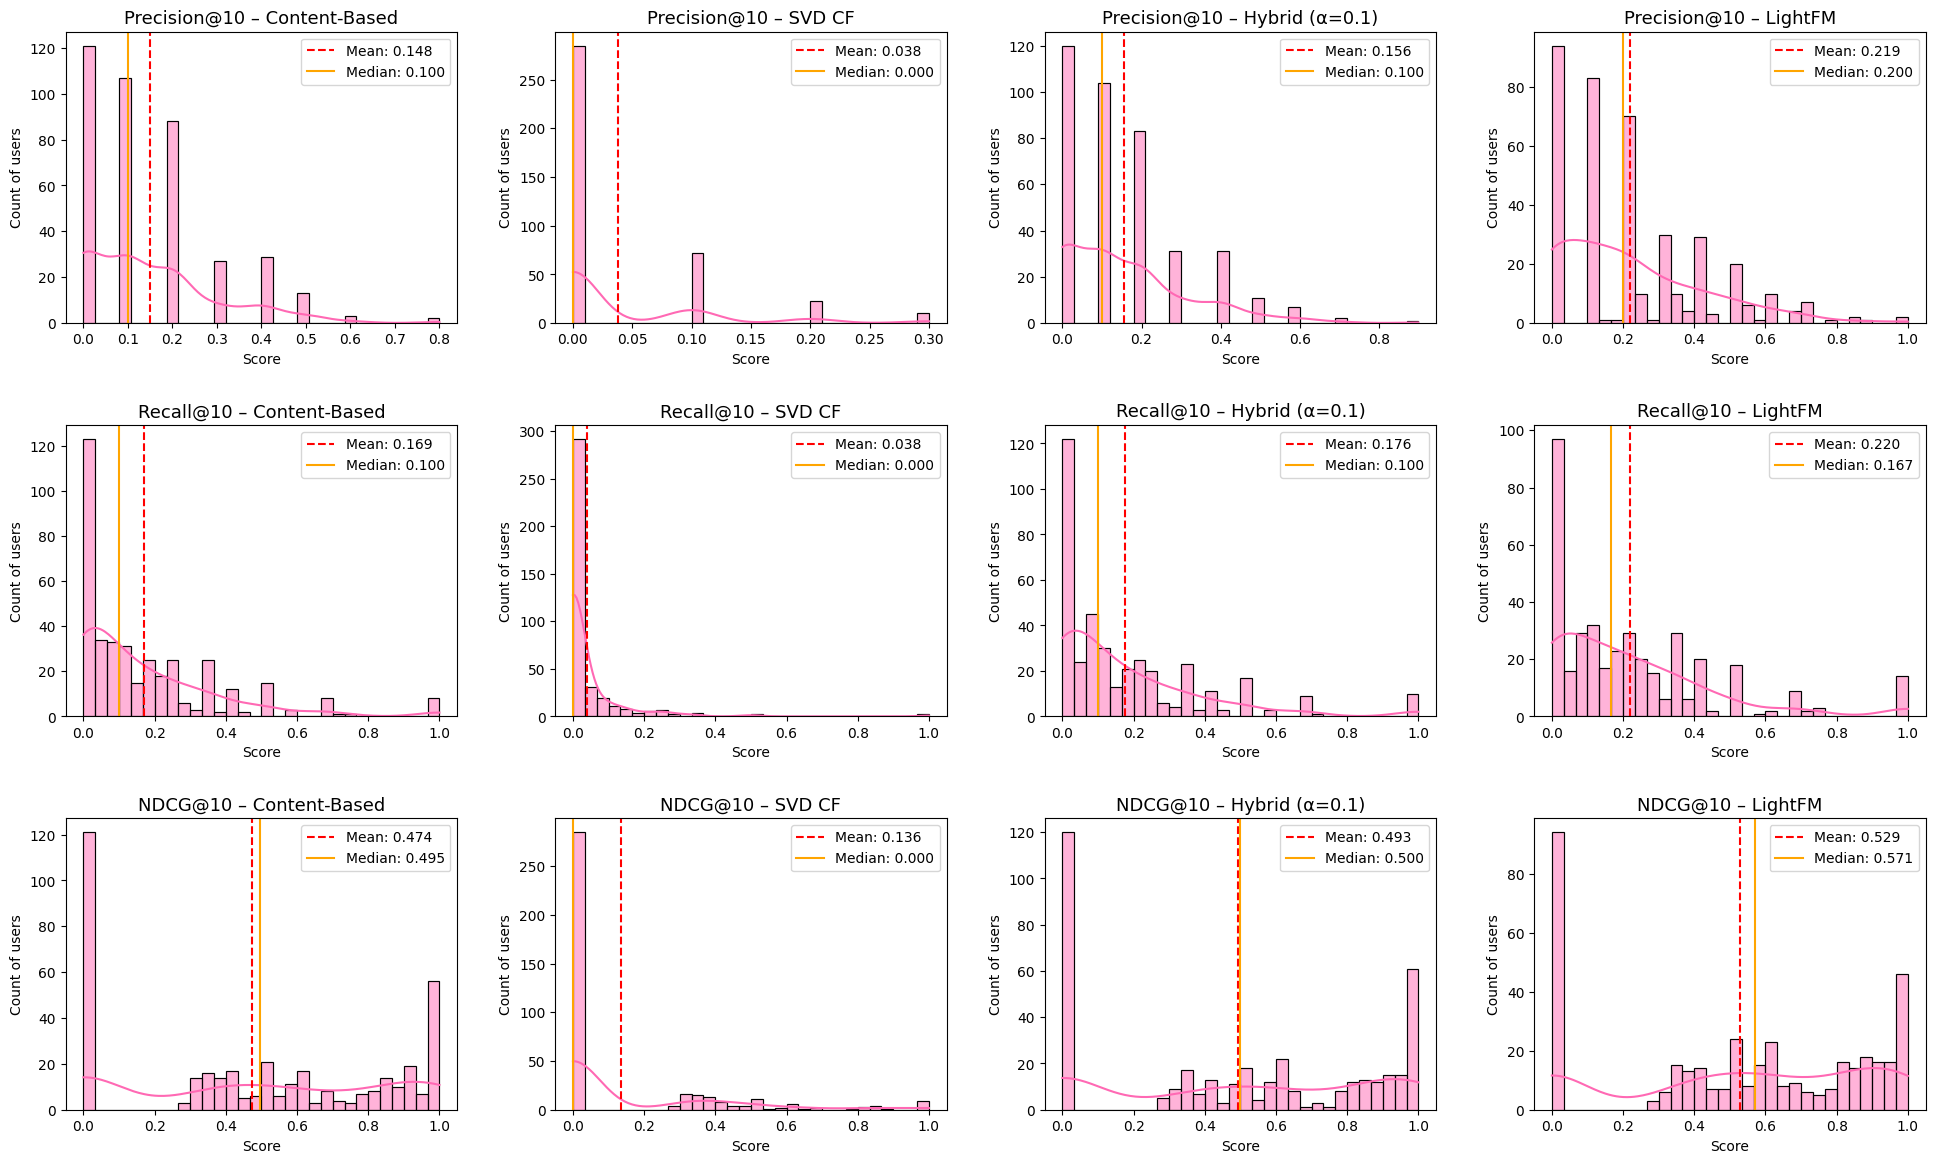

In [40]:
model_names = [
    "Content-Based",
    "SVD CF",
    f"Hybrid (α={best_alpha})",
    "LightFM",
]

prec_lists = [p_cb_u, p_cf_u, p_hy_u, p_lf_u]
rec_lists  = [r_cb_u, r_cf_u, r_hy_u, r_lf_u]
ndcg_lists = [n_cb_u, n_cf_u, n_hy_u, n_lf_u]

metric_lists = [prec_lists, rec_lists, ndcg_lists]
metric_titles = ["Precision@10", "Recall@10", "NDCG@10"]

fig, axes = plt.subplots(3, 4, figsize=(24, 14))
plt.subplots_adjust(hspace=0.35, wspace=0.25)

for row_idx, (scores_per_model, metric_title) in enumerate(zip(metric_lists, metric_titles)):
    for col_idx, (name, scores) in enumerate(zip(model_names, scores_per_model)):
        ax = axes[row_idx, col_idx]

        sns.histplot(scores, bins=30, kde=True, ax=ax, color="#ff69b4", edgecolor="black")

        mean_val = np.mean(scores)
        median_val = np.median(scores)

        ax.axvline(mean_val, color="red", linestyle="--", label=f"Mean: {mean_val:.3f}")
        ax.axvline(median_val, color="orange", linestyle="-", label=f"Median: {median_val:.3f}")

        ax.set_title(f"{metric_title} – {name}", fontsize=13)
        ax.set_xlabel("Score")
        ax.set_ylabel("Count of users")
        ax.legend()

plt.show()
